In [ ]:
#update the host of apt-get update
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [979 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [833 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://developer.download.nvidia.com

In [ ]:
#install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Get Install the Java Development Kit
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Get Spark lib -- address need to be change according to the current version of Spark: https://downloads.apache.org/spark/
!wget -q http://apache.osuosl.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
#Unzip th Spark
!tar xf spark-3.2.4-bin-hadoop3.2.tgz
#install findspark for Python
!pip install -q findspark
#Install extra lib(s)
!pip install -q xlrd
!pip install -q kaggle
!pip install -q kora
#import and set environment for spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

import kora
import pandas as pd

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *

SPARK_URL = "local[*]"

spark = SparkSession.builder.master(SPARK_URL).getOrCreate()

# Check the pyspark version
import pyspark
print(pyspark.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.6 MB/s eta 0:00:00
3.2.4


# Getting data from Kaggle

I can download data from Kaggle by using auto pipeline like this one.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

#Adding API code here
!kaggle datasets download -d mishra5001/credit-card


Mounted at /content/gdrive
 99% 111M/112M [00:01<00:00, 106MB/s]  
100% 112M/112M [00:01<00:00, 74.2MB/s]


In [ ]:
!unzip /content/credit-card.zip && rm /content/credit-card.zip

Archive:  /content/credit-card.zip
  inflating: application_data.csv    
  inflating: columns_description.csv  
  inflating: previous_application.csv  


#Loading Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler,SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#Reading Dataset

In [ ]:
file_path = "./application_data.csv"

#df_spark = spark.read.options(header="true",inferschema = "true").csv(file_path)

#pandas dataframe
df_pandas = pd.read_csv(file_path)
df_pandas_1 = df_pandas.copy()
df_pandas.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_pandas_1['TARGET'] = df_pandas_1['TARGET'].astype(str)

#Exploratory Data Analysis

## Categorical Data

In [ ]:
print("Object type values:",np.count_nonzero(df_pandas.select_dtypes('object').columns))
print("___________________________________________________________________________________________")
print(df_pandas.select_dtypes('object').columns)
print("___________________________________________________________________________________________")

Object type values: 16
___________________________________________________________________________________________
Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')
___________________________________________________________________________________________


In [ ]:
def colors(value):
    if value > 50 and value < 100:
        color = 'red'
    elif value > 154000 and value < 250000:
        color = 'red'
    elif value == 1 :
        color = 'blue'
    else:
        color = 'green'
    return 'color: %s' % color

def missing(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[total>0]
    percent = df.isnull().sum().sort_values(ascending = False)/len(df)*100
    percent = percent[percent>0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percentage']).style.applymap(colors)
missing(df_pandas.select_dtypes('object'))

,Total,Percentage
FONDKAPREMONT_MODE,210295,68.386172
WALLSMATERIAL_MODE,156341,50.840783
HOUSETYPE_MODE,154297,50.176091
EMERGENCYSTATE_MODE,145755,47.398304
OCCUPATION_TYPE,96391,31.345545
NAME_TYPE_SUITE,1292,0.420148



Missing value Imputation : Mode

In [ ]:
def mode_impute(df,col):
    return df[col].fillna(df[col].mode()[0])
df_pandas_1['FONDKAPREMONT_MODE'] = mode_impute(df_pandas_1,'FONDKAPREMONT_MODE')
df_pandas_1['WALLSMATERIAL_MODE'] = mode_impute(df_pandas_1,'WALLSMATERIAL_MODE')
df_pandas_1['HOUSETYPE_MODE'] = mode_impute(df_pandas_1,'HOUSETYPE_MODE')
df_pandas_1['EMERGENCYSTATE_MODE'] = mode_impute(df_pandas_1,'EMERGENCYSTATE_MODE')
df_pandas_1['OCCUPATION_TYPE'] = mode_impute(df_pandas_1,'OCCUPATION_TYPE')
df_pandas_1['NAME_TYPE_SUITE'] = mode_impute(df_pandas_1,'NAME_TYPE_SUITE')
missing(df_pandas_1.select_dtypes('object'))

,Total,Percentage


Descriptive Statistics

In [ ]:
df_pandas_1.describe(include=['O'])

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511
unique,2,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,282686,278232,202448,202924,213312,249818,158774,218391,196432,272868,151577,53901,67992,284125,304800,222381,305183


Label Encoding

In [ ]:
le = LabelEncoder()
df_pandas_1['NAME_CONTRACT_TYPE'] = le.fit_transform(df_pandas_1['NAME_CONTRACT_TYPE'])
df_pandas_1['CODE_GENDER'] = le.fit_transform(df_pandas_1['CODE_GENDER'])
df_pandas_1['FLAG_OWN_CAR'] = le.fit_transform(df_pandas_1['FLAG_OWN_CAR'])
df_pandas_1['FLAG_OWN_REALTY'] = le.fit_transform(df_pandas_1['FLAG_OWN_REALTY'])
df_pandas_1['NAME_TYPE_SUITE'] = le.fit_transform(df_pandas_1['NAME_TYPE_SUITE'].astype(str))
df_pandas_1['NAME_INCOME_TYPE'] = le.fit_transform(df_pandas_1['NAME_INCOME_TYPE'])
df_pandas_1['NAME_EDUCATION_TYPE'] = le.fit_transform(df_pandas_1['NAME_EDUCATION_TYPE'])
df_pandas_1['NAME_FAMILY_STATUS'] = le.fit_transform(df_pandas_1['NAME_FAMILY_STATUS'])
df_pandas_1['NAME_HOUSING_TYPE'] = le.fit_transform(df_pandas_1['NAME_HOUSING_TYPE'])
df_pandas_1['OCCUPATION_TYPE'] = le.fit_transform(df_pandas_1['OCCUPATION_TYPE'].astype(str))
df_pandas_1['WEEKDAY_APPR_PROCESS_START'] = le.fit_transform(df_pandas_1['WEEKDAY_APPR_PROCESS_START'])
df_pandas_1['ORGANIZATION_TYPE'] = le.fit_transform(df_pandas_1['ORGANIZATION_TYPE'])
df_pandas_1['FONDKAPREMONT_MODE'] = le.fit_transform(df_pandas_1['FONDKAPREMONT_MODE'].astype(str))
df_pandas_1['HOUSETYPE_MODE'] = le.fit_transform(df_pandas_1['HOUSETYPE_MODE'].astype(str))
df_pandas_1['WALLSMATERIAL_MODE'] = le.fit_transform(df_pandas_1['WALLSMATERIAL_MODE'].astype(str))
df_pandas_1['EMERGENCYSTATE_MODE'] = le.fit_transform(df_pandas_1['EMERGENCYSTATE_MODE'].astype(str))

##Numerical Data

In [ ]:
print("___________________________________________________________________________________________")
print("Int type values:",np.count_nonzero(df_pandas_1.select_dtypes('int').columns))
print(df_pandas_1.select_dtypes('int').columns)
print("___________________________________________________________________________________________")

___________________________________________________________________________________________
Int type values: 56
Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_

In [ ]:
missing(df_pandas_1.select_dtypes('int'))

,Total,Percentage


In [ ]:
df_pandas_1.select_dtypes('int').agg(['count','min', 'max','mad','mean','median','quantile','kurt','skew','var','std'])

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
min,1.000020e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.562550e+05,1.000000,2.000000,1.000000,1.000000,19.000000,6.000000,7.000000,4.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mad,8.901023e+04,0.172295,0.449872,0.448869,0.424982,0.584180,1.262465,2.405981,1.152960,0.888522,...,0.000013,0.007025,0.005856,0.002416,0.019659,0.000533,0.016127,0.001189,0.001014,0.000670
mean,2.781805e+05,0.095213,0.341669,0.340108,0.693673,0.417052,5.222990,4.670288,3.188273,1.472312,...,0.000007,0.003525,0.002936,0.001210,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
median,2.782020e+05,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000,7.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
quantile,2.782020e+05,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000,7.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
kurt,-1.198988e+00,5.608127,-1.552688,-1.544365,-1.293917,7.904106,2.054315,-1.594849,-0.886789,2.035108,...,153752.999974,278.689823,335.552164,821.657064,95.735809,3745.195328,118.014535,1675.415835,1966.256856,2980.592507
skew,-1.200235e-03,2.758277,0.668053,0.675015,-0.840293,1.974604,-1.981496,-0.355076,-1.024621,1.538401,...,392.114779,16.753746,18.372533,28.699333,9.886111,61.214140,10.955080,40.956134,44.364897,54.612939
var,1.056582e+10,0.086148,0.224958,0.224435,0.212492,0.521459,3.142204,6.474607,1.686761,1.366291,...,0.000007,0.003513,0.002928,0.001208,0.009830,0.000267,0.008064,0.000595,0.000507,0.000335


Outlier Detection

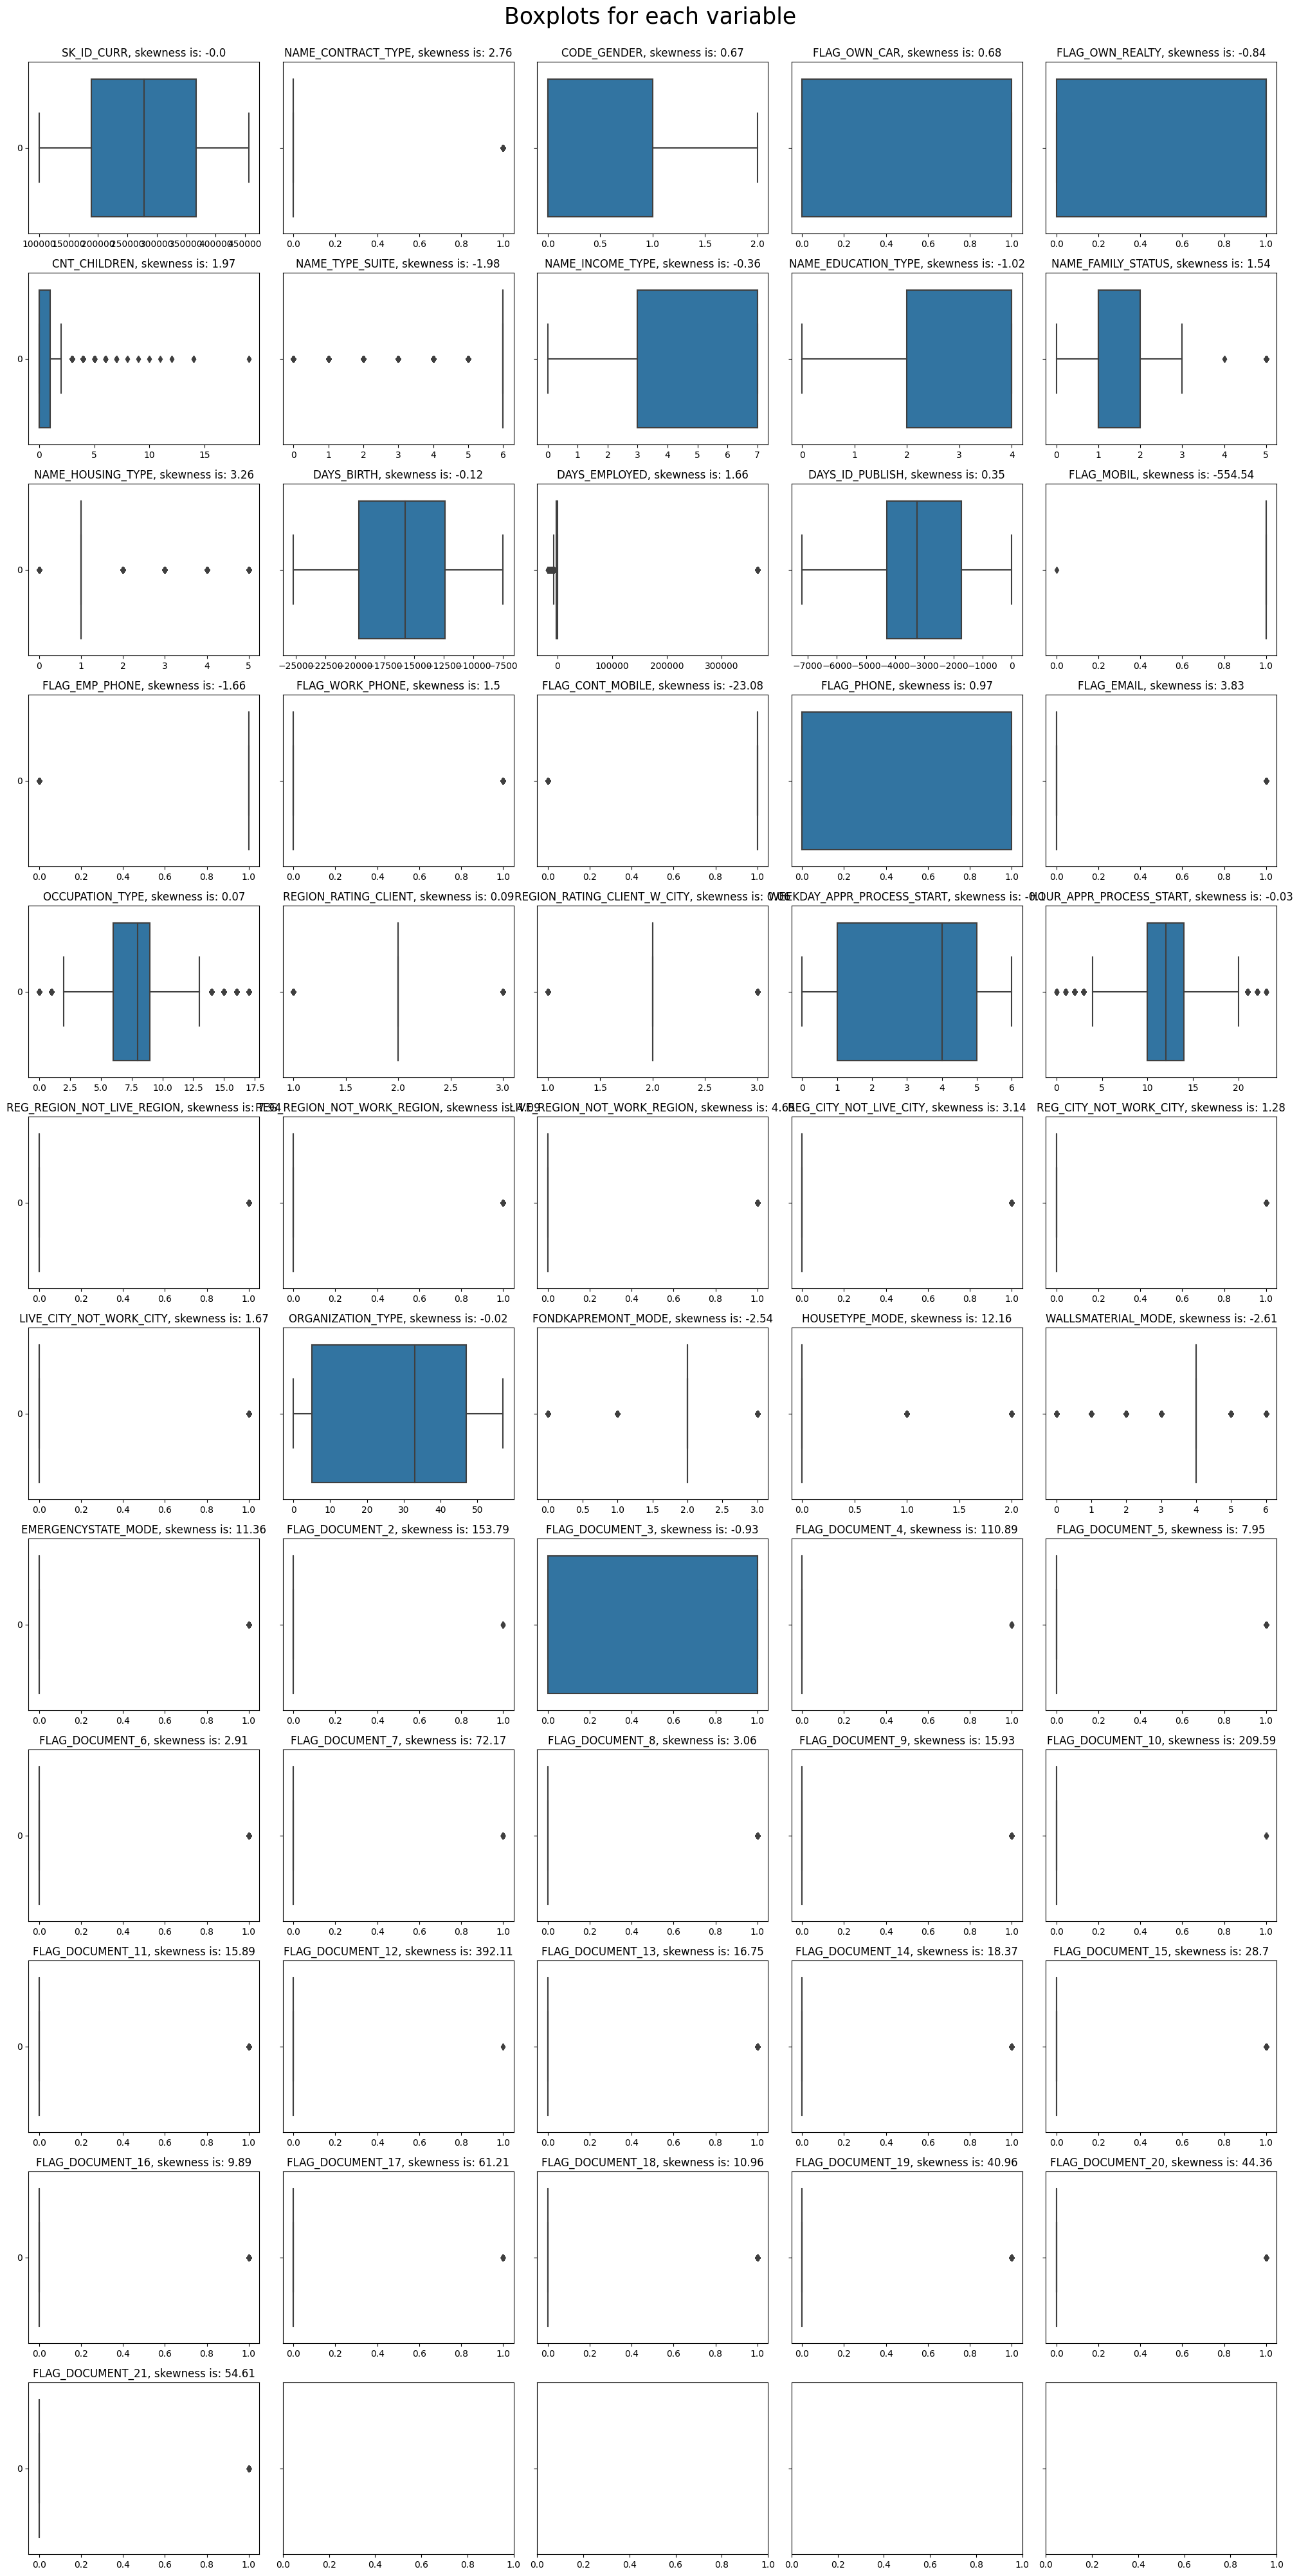

In [ ]:
int_columns = list(df_pandas_1.select_dtypes('int'))

# checking boxplots
def boxplots_custom(df, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(20,40))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=df[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(df[data].skew(axis = 0, skipna = True),2)))

boxplots_custom(df=df_pandas_1, columns_list=int_columns, rows=12, cols=5, suptitle='Boxplots for each variable')
plt.tight_layout()

Checking Distribution of variables using Histogram

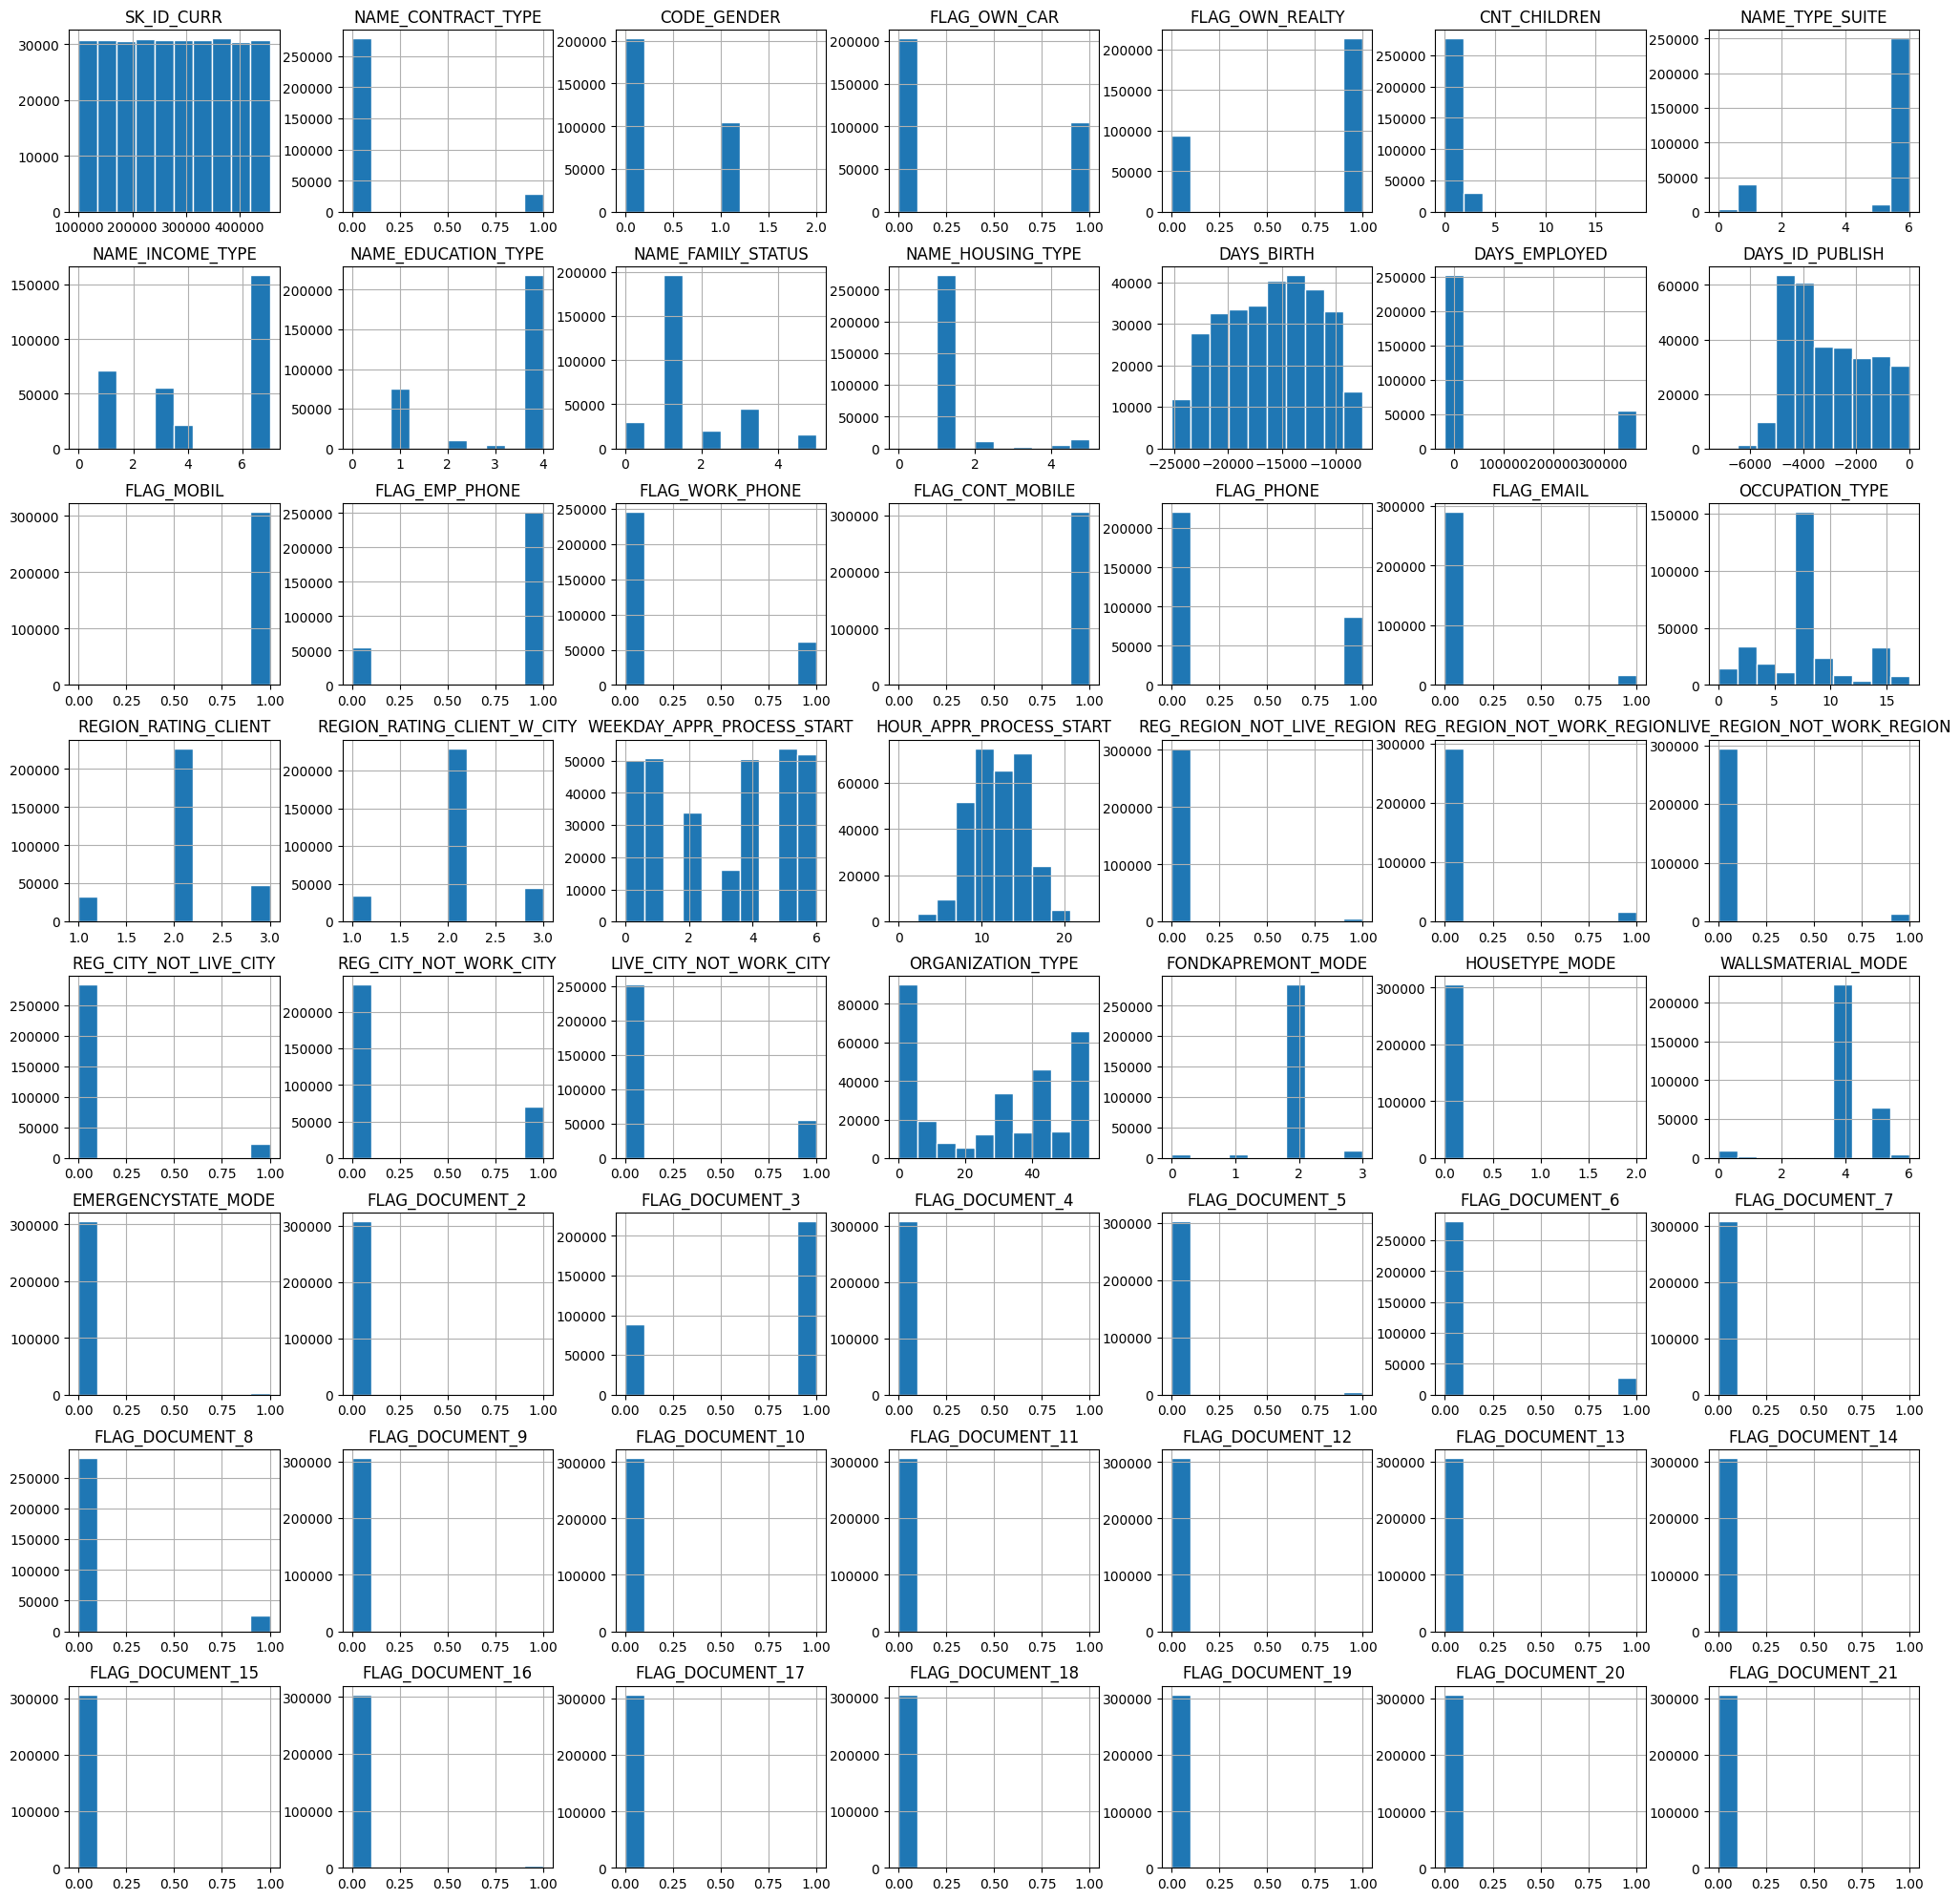

In [ ]:
df_pandas_1.select_dtypes('int').hist(figsize=(25,25), ec='w')
plt.show()

Relation Between Variables

In [ ]:
def color_(value):
    if value < 0 :
        color = 'red'
    elif value == 1 :
        color = 'blue'
    else:
        color = 'green'
    return 'color: %s' % color
df_pandas_1.select_dtypes('int').corr().style.applymap(color_)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,1.000000,0.001654,-0.000769,0.001216,0.000703,-0.001129,0.000954,-0.002112,-0.000529,0.002846,0.002191,-0.001500,0.001366,-0.000384,0.002804,-0.001337,-0.000415,0.002815,0.002753,0.000281,0.001439,-0.001075,-0.001138,0.002185,0.000350,-0.000283,0.001097,0.002903,-0.001885,-0.001582,0.000067,0.002269,-0.000136,0.001138,-0.001808,0.002549,0.000700,-0.003411,-0.004139,-0.001097,0.002121,-0.002694,0.001809,0.001505,-0.000815,-0.002012,-0.001045,0.000896,-0.001077,0.002604,-0.000724,0.001450,0.000509,0.000167,0.001073,0.000282
NAME_CONTRACT_TYPE,0.001654,1.000000,-0.008613,0.004022,0.067177,0.029998,0.012007,0.005428,-0.065086,0.011272,0.024190,0.086364,-0.054450,0.052847,0.000585,0.054938,-0.033647,-0.097116,-0.021378,-0.010811,0.001657,-0.021593,-0.023116,-0.006925,0.035897,0.018561,0.015774,0.007941,0.013586,0.004487,-0.004999,-0.040187,-0.004563,0.000037,-0.001333,-0.000339,-0.002109,-0.479724,0.004448,0.029372,-0.098808,0.042703,-0.084961,-0.006592,0.014708,0.025995,-0.000827,-0.004900,0.000005,-0.007783,-0.023433,-0.000548,-0.007530,-0.005190,-0.007308,0.055821
CODE_GENDER,-0.000769,-0.008613,1.000000,0.345833,-0.044340,0.047403,0.029996,0.065089,0.009554,-0.099713,0.058767,0.148080,-0.156018,0.000130,-0.002503,0.157253,0.034030,-0.006017,-0.019429,0.018218,-0.038149,-0.017862,-0.017263,-0.000271,0.007177,0.023683,0.103437,0.106060,0.048237,0.137541,0.133239,-0.163879,-0.003186,-0.004761,-0.005906,-0.005174,-0.001520,-0.087338,-0.002693,0.003255,-0.100766,-0.002059,0.249767,-0.008070,0.000874,0.004830,0.000851,0.040447,0.000947,0.020888,0.000061,0.003772,0.022205,0.004632,0.003258,0.023908
FLAG_OWN_CAR,0.001216,0.004022,0.345833,1.000000,-0.002817,0.102023,0.004256,0.033186,-0.093977,-0.131014,-0.004041,0.129879,-0.154441,0.013661,-0.002512,0.154659,0.011471,-0.006644,-0.007588,0.032105,-0.043720,-0.022668,-0.021405,0.002346,0.014369,-0.000668,0.038937,0.046352,0.003123,0.076081,0.088061,-0.114162,-0.005874,-0.007063,-0.012000,-0.007584,-0.000445,-0.070000,-0.001144,-0.013661,-0.106012,0.000958,0.228368,-0.011069,0.000891,-0.000456,0.003552,0.080647,0.003410,0.045909,0.001984,-0.002476,-0.000097,0.002184,0.007299,0.006741
FLAG_OWN_REALTY,0.000703,0.067177,-0.044340,-0.002817,1.000000,-0.002366,-0.050326,-0.026539,0.022130,0.000521,-0.199722,-0.119146,0.069677,0.006664,-0.001198,-0.070021,-0.114043,0.008526,-0.041507,0.029247,0.010022,0.001289,0.001884,-0.003414,-0.102687,-0.036301,-0.032316,-0.018324,-0.061709,-0.061889,-0.035991,0.050389,0.004673,-0.008986,0.002159,-0.008535,0.003236,-0.036839,0.002080,-0.011922,0.041567,0.003093,-0.035077,-0.003513,0.003171,-0.035201,-0.001071,-0.057484,-0.054678,-0.035729,-0.092272,-0.014207,-0.087687,-0.019364,-0.025130,-0.000173
CNT_CHILDREN,-0.001129,0.029998,0.047403,0.102023,-0.002366,1.000000,-0.013277,0.102547,-0.034128,-0.165475,0.021737,0.330938,-0.239818,-0.028019,0.001041,0.240714,0.055630,-0.000794,-0.029906,0.022619,-0.013482,0.025423,0.024781,-0.003419,-0.007292,-0.013319,0.008185,0.014835,0.0200

##Float Type Value

In [ ]:
print("___________________________________________________________________________________________")
print("float type values:",np.count_nonzero(df_pandas_1.select_dtypes('float').columns))
print(df_pandas_1.select_dtypes('float').columns)
print("___________________________________________________________________________________________")

___________________________________________________________________________________________
float type values: 65
Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       '

Missing Value detection

In [ ]:
missing(df_pandas_1.select_dtypes('float'))

,Total,Percentage
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
FLOORSMIN_MEDI,208642,67.848630


Missing Value Imputation

When you call interpolate() with method='linear', it performs linear interpolation on the missing values in a pandas DataFrame or Series. Linear interpolation estimates the missing values by taking the average of the previous and next valid values.

The limit_direction='forward' parameter specifies that the interpolation should only be performed in the forward direction. This means that missing values are filled using values that occur after them in the data.

In [ ]:
df_pandas_1[df_pandas_1.select_dtypes('float').columns]= df_pandas_1.select_dtypes('float').interpolate(method ='linear', limit_direction ='forward')
missing(df_pandas_1.select_dtypes('float'))

,Total,Percentage
OWN_CAR_AGE,2,0.000650


In [ ]:
df_pandas_1 = df_pandas_1.dropna(axis = 1)
missing(df_pandas_1)

,Total,Percentage


In [ ]:
df_pandas_1.select_dtypes('float').agg(['count','min', 'max','mad','mean','median','quantile','kurt','skew','var','std'])

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,3.075110e+05,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
min,2.565000e+04,4.500000e+04,1.615500e+03,4.050000e+04,0.000290,-2.467200e+04,1.000000,0.014568,8.173617e-08,0.000527,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.170000e+08,4.050000e+06,2.580255e+05,4.050000e+06,0.072508,0.000000e+00,20.000000,0.962693,8.549997e-01,0.896010,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000
mad,6.622635e+04,3.165837e+05,1.097530e+04,2.884883e+05,0.010291,2.915440e+03,0.665868,0.152637,1.570596e-01,0.153255,...,0.253828,1.637886,0.183205,696.277258,0.012861,0.013943,0.066335,0.436944,0.418749,1.402220
mean,1.687979e+05,5.990260e+05,2.710871e+04,5.383604e+05,0.020868,-4.986120e+03,2.152666,0.502585,5.144101e-01,0.511090,...,0.143411,1.405364,0.100034,-962.861007,0.006476,0.007016,0.034422,0.267442,0.265182,1.900000
median,1.471500e+05,5.135310e+05,2.490300e+04,4.500000e+05,0.018850,-4.504000e+03,2.000000,0.505755,5.658970e-01,0.531686,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000
quantile,1.471500e+05,5.135310e+05,2.490300e+04,4.500000e+05,0.018850,-4.504000e+03,2.000000,0.505755,5.658970e-01,0.531686,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000
kurt,1.917866e+05,1.934041e+00,7.707404e+00,2.433643e+00,3.260065,-3.213466e-01,2.802005,-0.706626,-2.672418e-01,-0.541585,...,126.293777,1409.968649,86.561590,-0.308589,254.685070,1158.746016,168.495565,91.790180,46026.739270,2.083440
skew,3.915597e+02,1.234778e+00,1.579753e+00,1.349216e+00,1.488009,-5.908716e-01,0.987543,-0.069806,-7.937717e-01,-0.409159,...,5.182534,12.064497,5.277539,-0.713598,14.416563,26.936552,9.250658,7.789479,134.756150,1.240985
var,5.622739e+10,1.619988e+11,2.100630e+08,1.364210e+11,0.000191,1.241073e+07,0.829336,0.033811,3.646363e-02,0.034387,...,0.199237,5.653536,0.131054,683611.564356,0.006617,0.011528,0.039118,0.783139,0.571452,3.267015


outliner

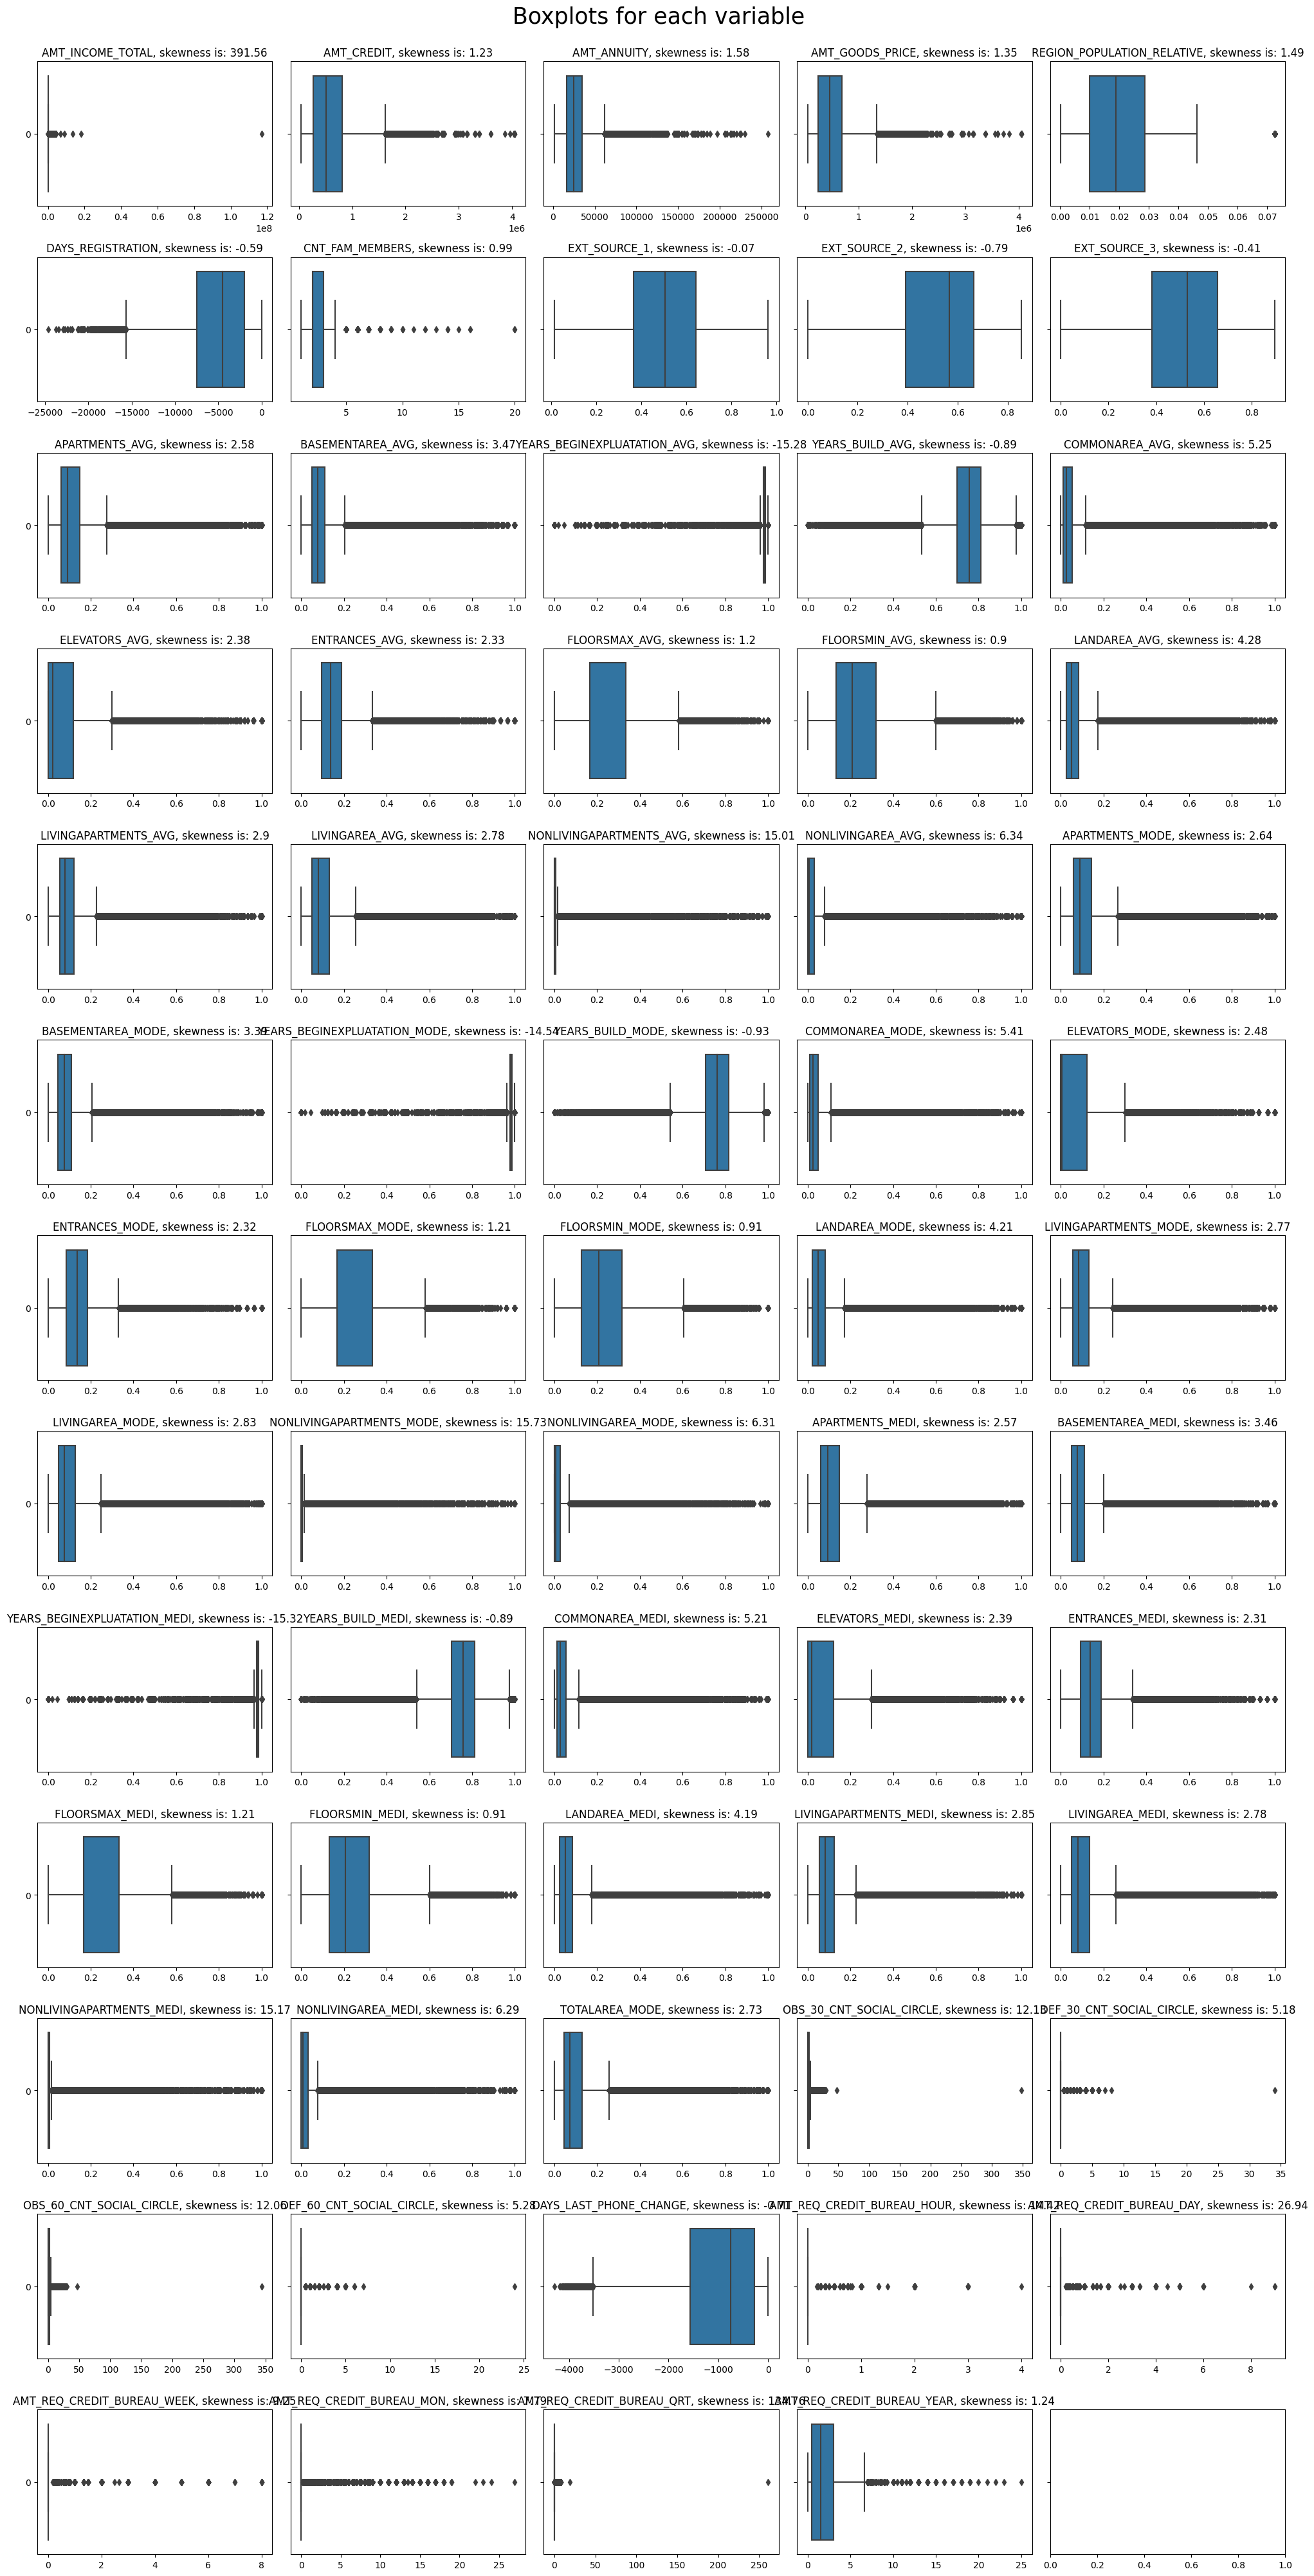

In [ ]:
float_columns = list(df_pandas_1.select_dtypes('float'))
boxplots_custom(df=df_pandas_1, columns_list=float_columns, rows=13, cols=5, suptitle='Boxplots for each variable')
plt.tight_layout()

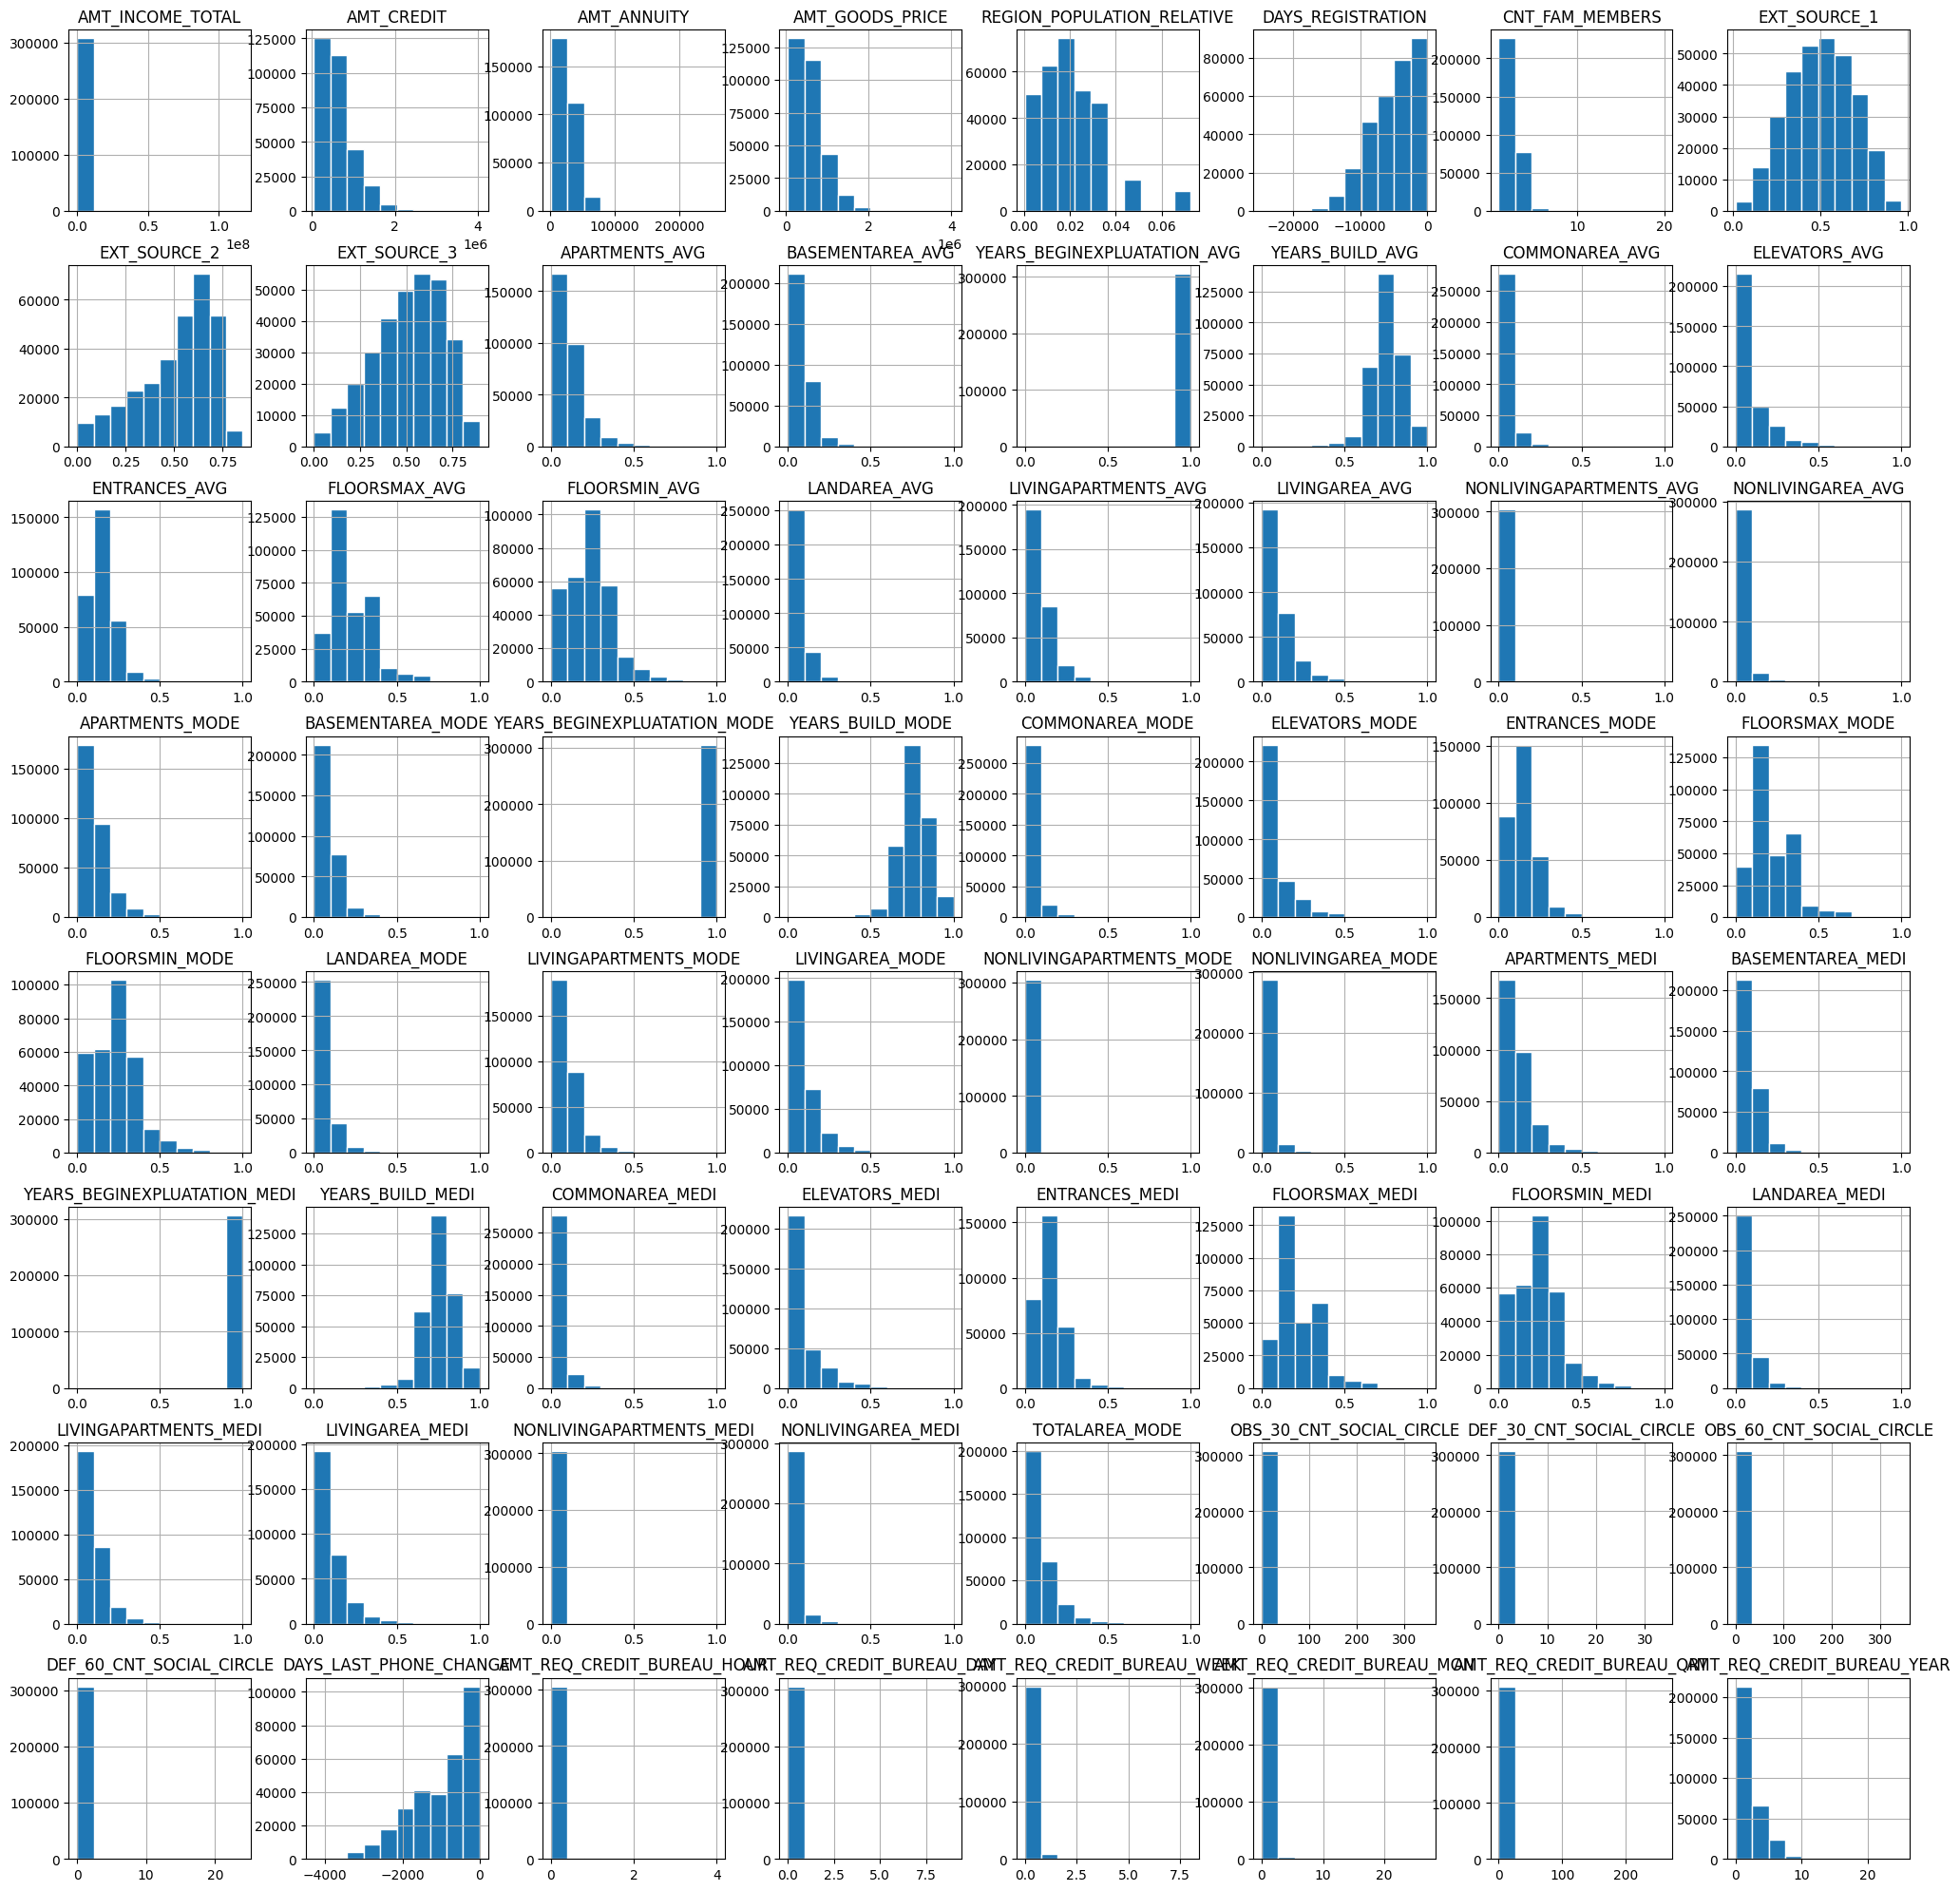

In [ ]:
df_pandas_1.select_dtypes('float').hist(figsize=(25,25), ec='w')
plt.show()

In [ ]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []

    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers
        outlier_list.extend(outlier_list_column)

    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )

    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]

    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])

    return multiple_outliers

In [ ]:
outliers_IQR = IQR_method(df_pandas_1,1,float_columns)
df_out = df_pandas_1.drop(outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 7347


In [ ]:
df_out.select_dtypes('float').corr().style.applymap(color_)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
AMT_INCOME_TOTAL,1.000000,0.077048,0.094654,0.077222,0.016399,0.016915,0.010282,0.004377,0.024268,-0.022684,0.004601,0.001747,0.003612,0.000952,0.000769,0.003573,0.002945,0.008422,0.005714,0.000226,0.004204,0.005210,-0.003047,-0.004203,0.004145,0.001472,0.003716,0.000900,0.000531,0.003189,0.002760,0.008134,0.005560,-0.000214,0.003874,0.004625,-0.004652,-0.004718,0.004489,0.001694,0.003630,0.000950,0.000711,0.003510,0.002981,0.008272,0.005743,0.000192,0.004230,0.005147,-0.004570,-0.004455,0.005907,-0.005356,-0.004438,-0.005240,nan,-0.009762,-0.001083,-0.000349,-0.003086,0.003229,-0.004935,0.009855
AMT_CREDIT,0.077048,1.000000,0.753395,0.982188,0.032090,0.002767,0.063488,0.065394,0.094782,0.023976,0.004670,-0.000030,0.012708,0.011163,0.002207,0.009259,0.002329,0.017693,0.010052,0.001233,0.002536,0.013457,-0.007275,-0.003823,0.002855,-0.001338,0.012703,0.011109,0.000604,0.008474,0.001368,0.016976,0.009662,0.001223,-0.000133,0.011183,-0.009647,-0.004173,0.003860,-0.000311,0.013282,0.011251,0.002060,0.008896,0.002158,0.017456,0.009866,0.002469,0.001717,0.013182,-0.008524,-0.004301,0.013005,0.011123,-0.007610,0.011506,nan,-0.077020,-0.004165,-0.005062,-0.014546,0.017118,-0.008498,-0.032536
AMT_ANNUITY,0.094654,0.753395,1.000000,0.753825,0.040827,0.038913,0.077759,0.032946,0.087315,0.012911,0.006736,-0.001180,0.010851,0.007987,0.001273,0.012518,-0.002070,0.024036,0.012097,0.000132,0.003913,0.015832,-0.007601,-0.008707,0.004594,-0.003271,0.011108,0.007557,-0.000223,0.011747,-0.003347,0.023071,0.011442,-0.000967,0.001707,0.013629,-0.011295,-0.009487,0.006000,-0.001453,0.011180,0.007884,0.001211,0.012304,-0.002239,0.023367,0.011719,0.001303,0.003405,0.015817,-0.010149,-0.008942,0.014657,-0.000386,-0.009652,0.000386,nan,-0.064151,0.001662,0.000786,-0.001468,0.007009,-0.013268,0.004579
AMT_GOODS_PRICE,0.077222,0.982188,0.753825,1.000000,0.038968,0.004161,0.061049,0.069107,0.104014,0.027786,0.007804,0.002080,0.016781,0.013427,0.002031,0.012021,0.002359,0.021617,0.011703,0.002552,0.004143,0.016724,-0.007284,-0.004349,0.005773,0.000449,0.016551,0.013192,0.000012,0.011301,0.001316,0.020749,0.011227,0.002069,0.001178,0.014280,-0.010094,-0.004903,0.006993,0.001764,0.017214,0.013497,0.001754,0.011708,0.002256,0.021375,0.011552,0.003785,0.003254,0.016392,-0.008785,-0.004775,0.015957,0.010116,-0.008406,0.010544,nan,-0.081914,-0.003943,-0.004908,-0.015488,0.018218,-0.009843,-0.035700
REGION_POPULATION_RELATIVE,0.016399,0.032090,0.040827,0.038968,1.000000,-0.039749,-0.011469,0.028415,0.152285,0.001340,0.036055,0.000081,-0.047707,-0.044636,-0.001774,0.041371,-0.004612,0.060761,0.050136,-0.019255,0.015811,0.043982,-0.007355,-0.013826,0.031187,-0.006946,-0.050059,-0.045927,-0.006219,0.035546,-0.006350,0.053285,0.045803,-0.020405,0.011159,0.036901,-0.012240,-0.021394,0.034907,-0.0

In [ ]:
df_out = df_out.interpolate(method ='linear', limit_direction ='forward')
df_out = df_out.dropna(axis = 1)
missing(df_pandas_1)

,Total,Percentage


#Feature Engineering by Using Statistical Technique

In [ ]:
from scipy.stats import chi2_contingency
df_object = df_out[['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE','TARGET']]
significant_columns = []

for col in df_object.columns:
    if col != 'TARGET':
        contingency_table = pd.crosstab(df_object['TARGET'], df_object[col])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)

        alpha = 0.05  # significance level
        if p_value < alpha:
            significant_columns.append(col)
print("previous object type values:",np.count_nonzero(df_object.drop(columns = 'TARGET').columns))
print("Object type values:",np.count_nonzero(significant_columns))
print("Significant columns:", significant_columns)
df_object = df_object[significant_columns]

previous object type values: 16
Object type values: 14
Significant columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']


In [ ]:
from scipy.stats import f_oneway
significant_columns = []

df_target = df_out['TARGET']
df_float_var = df_out.select_dtypes('float')
df_continuous_var = pd.concat([df_target, df_float_var], axis=1)
for col in df_continuous_var.columns:
    if col != 'TARGET':
        group_data = [df_continuous_var[df_continuous_var['TARGET'] == cat][col] for cat in df_continuous_var['TARGET'].unique()]
        f_statistic, p_value = f_oneway(*group_data)

        alpha = 0.05  # significance level
        if p_value < alpha:
            significant_columns.append(col)
print("previous int type values:",np.count_nonzero(df_continuous_var.drop(columns = 'TARGET').columns))
print("Continuous_variable_count: ",np.count_nonzero(significant_columns))
print("Significant columns:", significant_columns)

df_continuous_var = df_continuous_var[significant_columns]

previous int type values: 64
Continuous_variable_count:  42
Significant columns: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [ ]:
df = pd.concat([ df_target,df_continuous_var, df_object], axis=1)

In [ ]:
df.shape

(149756, 57)

#Building Classification Model

In [ ]:
X = df.drop(columns='TARGET')
target = df['TARGET'].astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size= 0.3, random_state = 0)

In [ ]:
def ml_model(X_train,X_test, Y_train, Y_test):
  MLA = [LogisticRegression(),KNeighborsClassifier(),DecisionTreeClassifier(),GaussianNB()]
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)
  row_index = 0
  for alg in MLA:
    predicted = alg.fit(X_train, Y_train).predict(X_test)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, Y_train), 2)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, Y_test), 2)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(Y_test, predicted),2)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(Y_test, predicted),2)
    MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(Y_test, predicted),2)
    row_index+=1
  MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
  return MLA_compare

ml_model(X_train,X_test, Y_train, Y_test)

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
0,LogisticRegression,0.92,0.92,0.00,0.00,0.00
1,KNeighborsClassifier,0.92,0.91,0.17,0.02,0.04
3,GaussianNB,0.91,0.91,0.08,0.01,0.01
2,DecisionTreeClassifier,1.00,0.85,0.14,0.17,0.15


#Data Imbalance-Over Sampling & Smote


In [ ]:
print('before Oversampling:',Counter(Y_train))
oversample = RandomOverSampler(sampling_strategy='minority')
X_train1, Y_train1 = oversample.fit_resample(X_train, Y_train)
print('After Oversampling:',Counter(Y_train1))

before Oversampling: Counter({0: 96219, 1: 8610})
After Oversampling: Counter({0: 96219, 1: 96219})


In [ ]:
print('before SMOTE:',Counter(Y_train))
sm = SMOTE(sampling_strategy='minority')
X_train2, Y_train2 = sm.fit_resample(X_train, Y_train)
print('After SMOTE:',Counter(Y_train2))

before SMOTE: Counter({0: 96219, 1: 8610})
After SMOTE: Counter({0: 96219, 1: 96219})


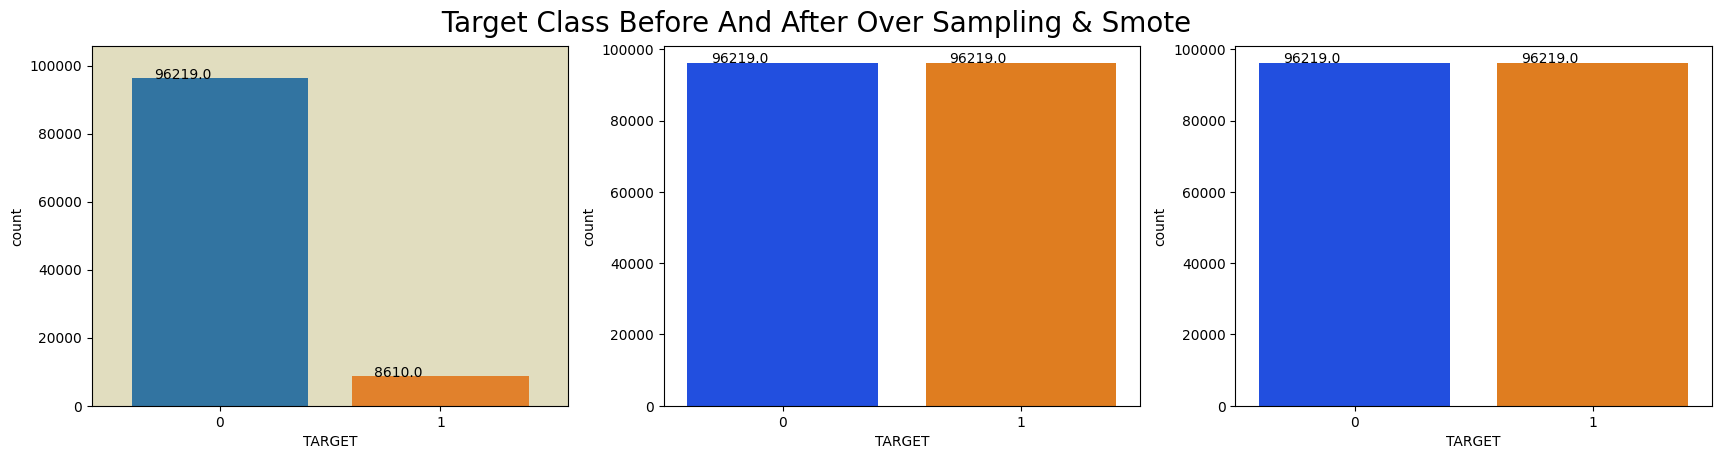

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18,4.5))
fig.subplots_adjust(bottom=0.10, left=0.10, top = 0.900, right=1.00)
fig.suptitle(' Target Class Before And After Over Sampling & Smote', fontsize = 20)

sns.countplot(x = Y_train, ax=ax1)
ax1.margins(0.1)
ax1.set_facecolor("#e1ddbf")
for p in ax1.patches:
        ax1.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_palette("bright")

sns.countplot(x = Y_train1, ax=ax2)
ax1.margins(0.1)
ax1.set_facecolor("#e1ddbf")
for p in ax2.patches:
        ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_palette("bright")

sns.countplot(x = Y_train2, ax=ax3)
ax1.margins(0.1)
ax1.set_facecolor("#e1ddbf")
for p in ax3.patches:
        ax3.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_palette("bright")

sns.set_style('dark')

Over Sampling Technique

In [ ]:
ml_model(X_train1,X_test, Y_train1, Y_test)

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
3,GaussianNB,0.50,0.90,0.09,0.02,0.03
2,DecisionTreeClassifier,1.00,0.85,0.13,0.15,0.14
1,KNeighborsClassifier,0.92,0.74,0.11,0.30,0.16
0,LogisticRegression,0.58,0.61,0.11,0.54,0.18


Smote Technique

In [ ]:
ml_model(X_train2,X_test, Y_train2, Y_test)

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
3,GaussianNB,0.50,0.89,0.09,0.03,0.05
2,DecisionTreeClassifier,1.00,0.81,0.11,0.19,0.14
1,KNeighborsClassifier,0.89,0.70,0.10,0.35,0.16
0,LogisticRegression,0.57,0.61,0.11,0.53,0.18
